# CliffWalking - Temporal-Difference

*Contact: Nagender Aneja, naneja@gmail.com, http://researchid.co/naneja

<img src='https://miro.medium.com/max/2420/1*52MwrYKyzQXuKZ88rqu70A.png'>

In [1]:
import sys
import gym
import numpy as np
import random
import math
np.set_printoptions(linewidth=100)
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [2]:
env = gym.make('CliffWalking-v0')

In [3]:
print(env.action_space) # UP, RIGHT, DOWN, LEFT
print(env.observation_space) # {0,..,47}

Discrete(4)
Discrete(48)


In [4]:
grid = np.zeros((4,12))
grid[0:13][0] = np.arange(0, 12)
grid[0:13][1] = np.arange(12, 24)
grid[0:13][2] = np.arange(24, 36)
grid[0:13][3] = np.arange(36, 48)
grid

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
       [36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.]])

## Optimal Policy

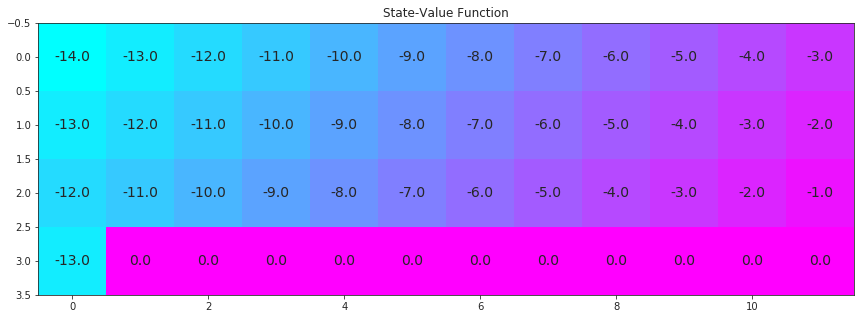

In [5]:
V_opt = np.zeros((4,12))
V_opt[0:13][0] = np.arange(-14, -2)
V_opt[0:13][1] = np.arange(-14, -2) + 1
V_opt[0:13][2] = np.arange(-14, -2) + 2
V_opt[3][0] = -13
plot_values(V_opt)

## Part 1: TD Control: Sarsa

In [6]:
# Returns updated Q-value for the most recent experience
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action]
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0
    
    target = reward + gamma * Qsa_next
    new_value = current + (alpha * (target - current))
    
    return new_value

In [7]:
# Selects epsilon-greedy action for supplied state
def epsilon_greedy(Q, state, nA, eps):
    if random.random() > eps:
        return np.argmax(Q[state]) # select greedy action with probability epsilon
    else:
        return random.choice(np.arange(env.action_space.n))

In [8]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    for i in range(num_episodes):
        score = 0
        state = env.reset()
        
        eps = 1.0 / (i+1)
        action = epsilon_greedy(Q, state, nA, eps)
        
        while True:
            next_state, reward, done, info = env.step(action)
            score += reward
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward)
                tmp_scores.append(score)
                break
        if (i+1) % plot_every == 0:
            print("\rEpisode {}/{}".format(i+1, num_episodes), end="")
            sys.stdout.flush()  
            avg_scores.append(np.mean(tmp_scores))
        
    xs = np.linspace(0, num_episodes, len(avg_scores), endpoint=False)
    plt.plot(xs, np.asarray(avg_scores))
        
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next {} Episodes)'.format(plot_every))
        
    print('Best Average Reward over {} Episodes: {}'.format(plot_every, np.max(avg_scores)))
    return Q

Episode 5000/5000Best Average Reward over 100 Episodes: -13.0


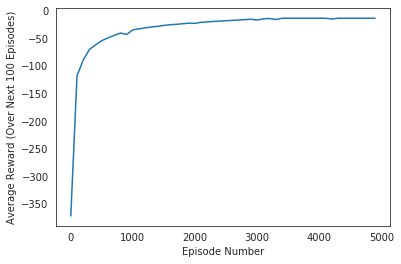

In [9]:
Q_sarsa = sarsa(env, 5000, .01)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  1  0  1  3  1  1  0  2  1  2]
 [ 0  0  1  1  2  3  1  2  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


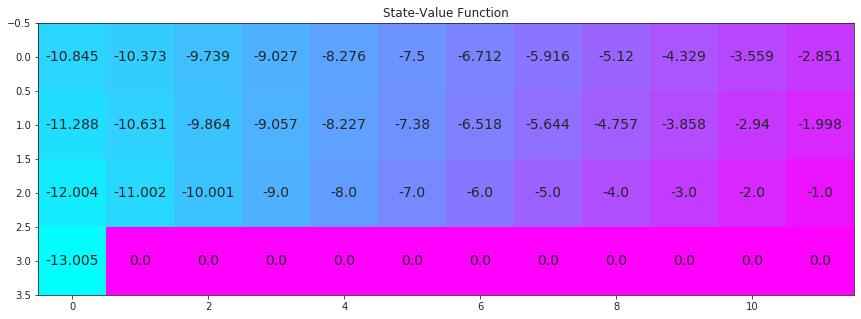

In [10]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)

check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

# Part 2: TD Control: Q-learning

In [11]:
# Returns updated Q-value for the most recent experience
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    current = Q[state][action]

    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0
    target = reward + gamma * Qsa_next
    
    new_value = current + alpha * (target - current)
    
    return new_value

In [13]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    for i in range(1, num_episodes+1):
        score = 0
        state = env.reset()
        eps = 1.0 / i
        while True:
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, \
                                                 next_state)
            state = next_state

            if done:
                tmp_scores.append(score)
                break
        if i % plot_every == 0:
            avg_scores.append(np.mean(tmp_scores))
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
            
    xv = np.linspace(0, num_episodes, len(avg_scores), endpoint=False)
    plt.plot(xv, np.asarray(avg_scores))

    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 5000/5000Best Average Reward over 100 Episodes:  -13.0


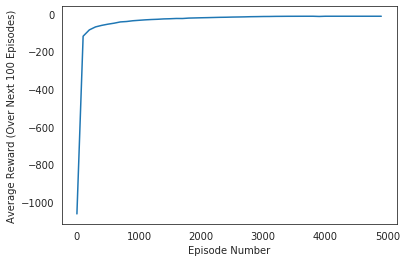

In [14]:
Q_sarsamax = q_learning(env, num_episodes=5000, alpha=.01, gamma=1.0)

In [17]:
policy_sarsamax = []
for key in np.arange(48):
    if key in Q_sarsamax:
        v = np.argmax(Q_sarsamax[key])
    else:
        v = -1
    policy_sarsamax.append(v)

policy_sarsamax = np.array(policy_sarsamax)
policy_sarsamax = policy_sarsamax.reshape((4,12))

check_test.run_check('td_control_check', policy_sarsamax)

**<span style="color: green;">PASSED</span>**

In [18]:
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  1  3  1  0  0  1  1  2]
 [ 3  1  0  3  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


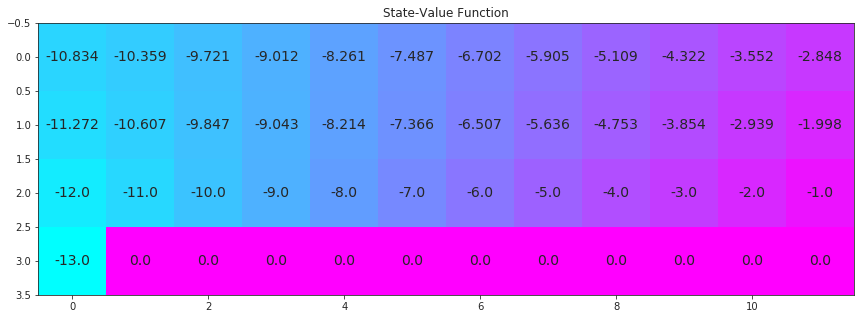

In [20]:
optimal_sv = []
for key in range(48):
    if key in Q_sarsamax:
        sv = np.max(Q_sarsamax[key])
    else:
        sv = 0
    optimal_sv.append(sv)

plot_values(optimal_sv)

# Part 3: TD Control: Expected Sarsa

In [22]:
# Returns updated Q-value for the most recent experience
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state):
    current = Q[state][action]
    
    policy_s = np.ones(nA) * eps / nA
    n_act = np.argmax(Q[next_state])
    policy_s[n_act] = 1 - eps + (eps / nA)
    
    Qsa_next = np.dot(Q[next_state], policy_s)
    target = reward + (gamma * Qsa_next)
    
    new_value = current + alpha * (target - current)
    return new_value

In [25]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    for i in range(1, num_episodes+1):
        score = 0
        state = env.reset()
        eps = 0.005
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, 
                                                state, action, reward, next_state)
            
            state = next_state
            
            if done:
                tmp_scores.append(score)
                break
        if i % plot_every == 0:
            avg_scores.append(np.mean(tmp_scores))
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()

    xv = np.linspace(0, num_episodes, len(avg_scores), endpoint=False)
    yv = np.asarray(avg_scores)
    plt.plot(xv, yv)
    
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)

    print(('\n Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 5000/5000
 Best Average Reward over 100 Episodes:  -13.0


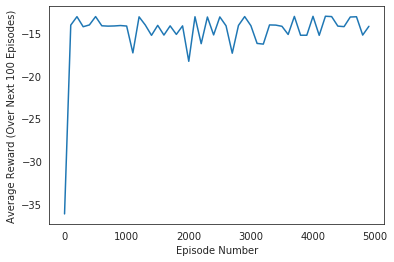

In [26]:
Q_expsarsa = expected_sarsa(env, 5000, 1)

In [28]:
policy_expsarsa = []
for key in np.arange(48):
    if key in Q_expsarsa:
        sv = np.argmax(Q_expsarsa[key])
    else:
        sv = -1
    policy_expsarsa.append(sv)
policy_expsarsa = np.array(policy_expsarsa).reshape(4, 12)

check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  3  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


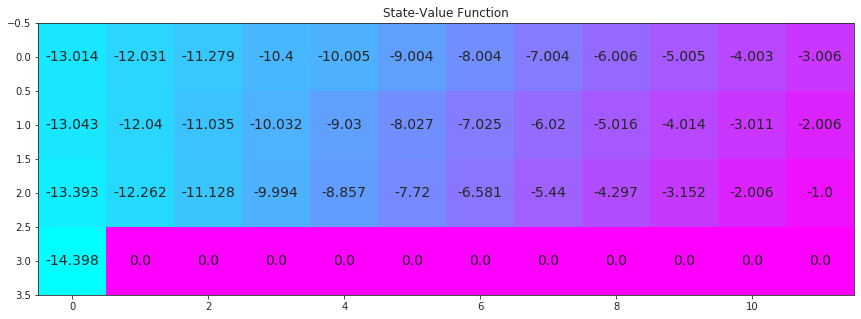

In [29]:
# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])